# Quick Code Analysis

To get going with this notebook I suggest using VS Code with Python extension.

Create a virtual environment in this folder:

```
python -m venv .venv
```

Select the Python Interpreter from the venv in the quick command menu (Ctrl/Cmd + Shift + P) -> `> Python: Select Interpreter` (refresh the interpreter list or reload the window if it does not show up).

Open a terminal, load the venv if that's not done automatically, and install pandas:

```
pip install pandas
```

Ensure `git` can be be found.

Change the variables below to point to your repo of interest, and give this notebook a spin (VS Code may ask if it needs to install a Jupyter kernel).

In [88]:
path = "../gtk"
after = "1 year ago"
top = 10

# Regex patterns to exclude from analisys. E.g. generated files.
excludes = [".*\\.svg$", ".*\\.xcf$", ".*\\.png$", ".*\\.gif$", ".*\\.md$", ".*\\.rst$", ".*\\.po$", ".*\\.gaphor$", "poetry.lock", "NEWS.*"]


In [89]:
import os
import re
import pandas
import functools
import itertools
import subprocess
from IPython.core.display import HTML

compiled_excludes = [re.compile(ex) for ex in excludes]


def is_excluded(filename):
    return any(re.search(ex, filename) for ex in compiled_excludes)


lines = []
found_commits = 0
with subprocess.Popen(["git", "log", "--format=format:::: %H,%ci,%an", "--numstat", "--no-renames", f"--after={after}"], cwd=path, stdout=subprocess.PIPE, text=True) as git_log:
    for line in git_log.stdout.readlines():
        line = line.strip()
        if not line:
            continue
        elif line.startswith("::: "):
            meta = line[4:].split(",")
            found_commits += 1
        else:
            try:
                added, removed, filename = line.split("\t", 2)
            except ValueError as e:
                print(f"Error on '{line}': {e}")
                continue
            if not is_excluded(filename):
                rec = [*meta, added, removed, filename]
                assert len(rec) == 6, rec
                lines.append(rec)

df = pandas.DataFrame(lines, columns=["commit", "date", "author", "added", "removed", "filename"])
df['dirname'] = df.apply(lambda row: os.path.dirname(row["filename"]), axis=1)
df['dirname2'] = df.apply(lambda row: os.path.dirname(row["dirname"]), axis=1)

del lines
# df[:top]
(found_commits, len(df))

(4178, 6974)

# Complexity

We use the simplest complexity metric of all: file size. This metric is language agnostic and tends to be a pretty good indicator for complexity.

In [90]:
from pathlib import Path

cwdpath = Path(path)

with subprocess.Popen(["git", "ls-files"], cwd=path, stdout=subprocess.PIPE, text=True) as git_ls_files:
    complexity = pandas.DataFrame(((line.strip(), os.stat(cwdpath / line.strip()).st_size) for line in git_ls_files.stdout.readlines() if not is_excluded(line.strip())), columns=["filename", "size"]).sort_values("size", ascending=False)

complexity[:top]

,filename,size
64,demos/gtk-demo/color.names.txt,3100196
193,demos/gtk-demo/listview_weather.txt,1809953
278,demos/gtk-demo/ucdnames.data,1228581
3144,testsuite/css/parser/keyframes-ordering.ref.css,753250
3143,testsuite/css/parser/keyframes-ordering.css,515625
2221,gtk/gtktreeview.c,478940
2396,gtk/roaring/roaring.c,470670
226,demos/gtk-demo/portland-rose.jpg,469879
2543,tests/portland-rose.jpg,469879
323,demos/widget-factory/portland-rose.jpg,469879


# Churn

Churn is simply how many times a file has changed in the history of a project. The more often it changed, the higher the "churn".

In [91]:
churn = df.groupby(['filename']).size().reset_index(name='commits').sort_values("commits", ascending=False)
churn[:top]

,filename,commits
1437,gtk/gtkwidget.c,75
1442,gtk/gtkwindow.c,73
1548,meson.build,69
1483,gtk/theme/Adwaita/_common.scss,67
567,gsk/ngl/gsknglrenderjob.c,62
485,gsk/gl/gskglrenderer.c,48
1400,gtk/gtktextview.c,47
382,gdk/wayland/gdksurface-wayland.c,47
310,gdk/gdksurface.c,46
992,gtk/gtkcomposetable.c,42


# Churn vs Complexity

This is a list of the most complicated files.

,filename,commits,size,churn_complexity
0,gtk/gtkwidget.c,75,404133,30309975
4,gtk/gtktextview.c,47,335800,15782600
1,gtk/gtkwindow.c,73,214010,15622730
28,gtk/gtktreeview.c,22,478940,10536680
3,gsk/ngl/gsknglrenderjob.c,62,162534,10077108
5,gdk/wayland/gdksurface-wayland.c,47,159791,7510177
9,gtk/gtklabel.c,39,174546,6807294
21,gtk/gtktext.c,27,230194,6215238
11,gsk/gskrendernodeimpl.c,37,167658,6203346
12,gdk/x11/gdksurface-x11.c,37,156029,5773073


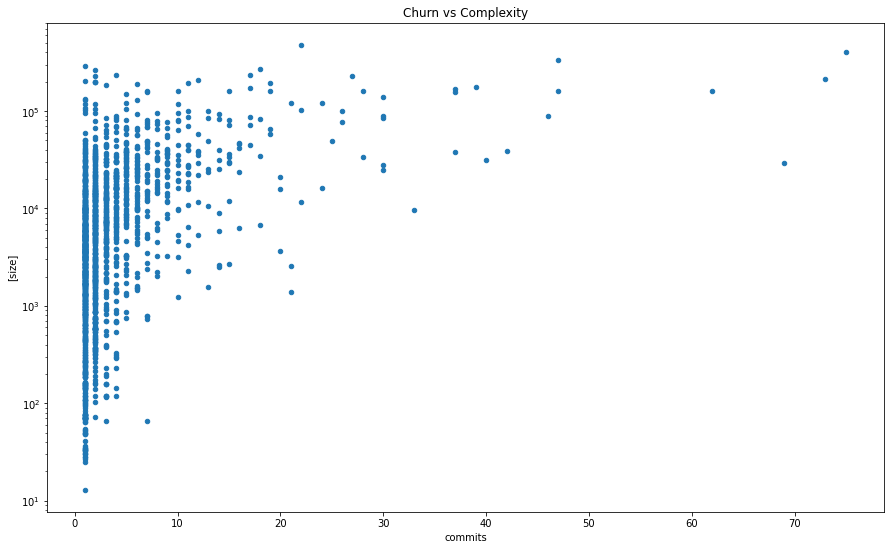

In [92]:
churn_complexity = pandas.merge(churn, complexity, on="filename", suffixes=("_ch", "_co"))
churn_complexity["churn_complexity"] = churn_complexity.apply(lambda row: row["commits"] * row["size"], axis=1)

churn_complexity.plot.scatter(x="commits", y=["size"], title="Churn vs Complexity", figsize=(15,9), logy=True, logx=False)

churn_complexity.sort_values("churn_complexity", ascending=False)[:top]

# Top authors

The authors that contributed most to the repository.

In [93]:
top_authors = df.groupby(['author']).size().reset_index(name='commits').sort_values("commits", ascending=False)
top_authors[:top]

,author,commits
62,Matthias Clasen,4036
29,Emmanuele Bassi,714
9,Benjamin Otte,683
47,Jonas Ådahl,250
17,Christian Hergert,203
89,Timm Bäder,151
19,Chun-wei Fan,104
2,Alexander Mikhaylenko,91
4,Arnaud Bonatti,90
38,Jakub Steiner,72


In [94]:
top_authors_per_package = df.groupby(['dirname', 'author']).size().reset_index(name='commits').sort_values("commits", ascending=False)
top_authors_per_package[:top]

,dirname,author,commits
265,gtk,Matthias Clasen,1822
243,gtk,Emmanuele Bassi,284
107,gdk,Matthias Clasen,248
209,gsk/ngl,Matthias Clasen,156
167,gdk/x11,Benjamin Otte,150
45,demos/gtk-demo,Matthias Clasen,144
416,testsuite/gtk,Matthias Clasen,137
93,gdk,Benjamin Otte,121
191,gsk,Matthias Clasen,106
429,testsuite/reftests,Matthias Clasen,106


# Change Coupling

Change coupling tells us which files have a tendency to change together.

In [97]:
group_size = 2

def size(iterable):
    return functools.reduce(lambda n, _: n + 1, iterable, 0)

commits = {name: len(commits) for name, commits in df.groupby(["filename"])}

all_file_pairs = sorted(pair for _, group in df.groupby(['commit']) for pair in itertools.combinations(group['filename'], group_size))
combos = {pair: size(pairs) for pair, pairs in itertools.groupby(all_file_pairs)}

change_coupling = sorted(((n / (n + sum(commits[a] for a in combo)), n, *combo) for combo, n in combos.items()), reverse=1)[:top*5]

rows = (
    f"""
    <tr><td>{n}</td><td>{file_a}</td><td>{commits[file_a]}</td><td>{int(n / commits[file_a] * 100)}</td></tr>
    {''.join(f'<tr><td></td><td>{file_b}</td><td>{commits[file_b]}</td><td>{int(n / commits[file_b] * 100)}</td></tr>' for file_b in files)}
    """ for _, n, file_a, *files in change_coupling)

HTML(f"<table><th><td>Coupled Entities</td><td>Commits</td><td>% coupling</td></th>{''.join(rows)}</table>")

7,po-properties/POTFILES.in,7,100
,po/POTFILES.in,7,100
5,gsk/ngl/resources/linear_gradient.glsl,5,100
,gsk/ngl/resources/radial_gradient.glsl,5,100
5,gsk/ngl/resources/inset_shadow.glsl,5,100
,gsk/ngl/resources/outset_shadow.glsl,5,100
5,gsk/ngl/resources/border.glsl,5,100
,gsk/ngl/resources/outset_shadow.glsl,5,100
5,gsk/ngl/resources/border.glsl,5,100
,gsk/ngl/resources/inset_shadow.glsl,5,100
5,build-aux/flatpak/org.gtk.IconBrowser4.json,5,100
